# Predicting Car Prices

In this project, I show a machine learning workflow to predict a car's market price using its attributes. The data set we will be working with contains information on various cars. For each car we have information about the technical aspects of the vehicle such as the motor's displacement, the weight of the car, the miles per gallon, how fast the car accelerates, and more. You can read more about the data set __[here](http://)__ and can download it directly from __[here](http://url)__.

In [55]:
import pandas as pd
import numpy as np
from collections import OrderedDict
pd.options.display.max_columns = 99

In [56]:
cols = ['symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style', 
        'drive-wheels', 'engine-location', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-type', 
        'num-of-cylinders', 'engine-size', 'fuel-system', 'bore', 'stroke', 'compression-rate', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']
cars = pd.read_csv('imports-85.data', names=cols)
cars.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


In [57]:
# Select only the columns with continuous values from - https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.names
continuous_values_cols = ['normalized-losses', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'bore', 'stroke', 'compression-rate', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']
numeric_cars = cars[continuous_values_cols]

## Data Cleaning

In [58]:
numeric_cars= numeric_cars.replace(to_replace='?', value=np.nan)

In [59]:
numeric_cars.head()

,normalized-losses,wheel-base,length,width,height,curb-weight,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,NaN,88.6,168.8,64.1,48.8,2548,3.47,2.68,9.0,111,5000,21,27,13495
1,NaN,88.6,168.8,64.1,48.8,2548,3.47,2.68,9.0,111,5000,21,27,16500
2,NaN,94.5,171.2,65.5,52.4,2823,2.68,3.47,9.0,154,5000,19,26,16500
3,164,99.8,176.6,66.2,54.3,2337,3.19,3.40,10.0,102,5500,24,30,13950
4,164,99.4,176.6,66.4,54.3,2824,3.19,3.40,8.0,115,5500,18,22,17450


In [60]:
numeric_cars = numeric_cars.astype('float')
numeric_cars.isnull().sum()

normalized-losses    41
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
bore                  4
stroke                4
compression-rate      0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 4
dtype: int64

In [61]:

# Because `price` is the column we want to predict, let's remove any rows with missing `price` values.
numeric_cars = numeric_cars.dropna(subset=['price'])
numeric_cars.isnull().sum()

normalized-losses    37
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
bore                  4
stroke                4
compression-rate      0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 0
dtype: int64

In [62]:
# Replace missing values in other columns using column means.
numeric_cars = numeric_cars.fillna(numeric_cars.mean())

# Confirm that there's no more missing values!
numeric_cars.isnull().sum()

normalized-losses    0
wheel-base           0
length               0
width                0
height               0
curb-weight          0
bore                 0
stroke               0
compression-rate     0
horsepower           0
peak-rpm             0
city-mpg             0
highway-mpg          0
price                0
dtype: int64

In [63]:
# Normalize all columnns to range from 0 to 1 except the target column.
price_col = numeric_cars['price']
numeric_cars = (numeric_cars - numeric_cars.min())/(numeric_cars.max() - numeric_cars.min())
numeric_cars['price'] = price_col

## Univariate k-nearest neighbor model

In [64]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

def knn_train_test(train_col, target_col, df):
    knn = KNeighborsRegressor()
    np.random.seed(1)
        
    # Randomize order of rows in data frame.
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)

    # Divide number of rows in half and round.
    last_train_row = int(len(rand_df) / 2)
    
    # Select the first half and set as training set.
    # Select the second half and set as test set.
    train_df = rand_df.iloc[0:last_train_row]
    test_df = rand_df.iloc[last_train_row:]
    
    # Fit a KNN model using default k value.
    knn.fit(train_df[[train_col]], train_df[target_col])
    
    # Make predictions using model.
    predicted_labels = knn.predict(test_df[[train_col]])

    # Calculate and return RMSE.
    mse = mean_squared_error(test_df[target_col], predicted_labels)
    rmse = np.sqrt(mse)
    return rmse

rmse_results = OrderedDict()
train_cols = numeric_cars.columns.drop('price')

# For each column (minus `price`), train a model, return RMSE value
# and add to the dictionary `rmse_results`.
for col in train_cols:
    rmse_val = knn_train_test(col, 'price', numeric_cars)
    rmse_results[col] = rmse_val

# Create a Series object from the dictionary so 
# we can easily view the results, sort, etc
rmse_results_series = pd.Series(rmse_results)
rmse_results_series.sort_values()



horsepower           4037.037713
curb-weight          4401.118255
highway-mpg          4630.026799
width                4704.482590
city-mpg             4766.422505
length               5427.200961
wheel-base           5461.553998
compression-rate     6610.812153
bore                 6780.627785
normalized-losses    7330.197653
peak-rpm             7697.459696
stroke               8006.529545
height               8144.441043
dtype: float64

In [65]:
def knn_train_test(train_col, target_col, df):
    np.random.seed(1)
        
    # Randomize order of rows in data frame.
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)

    # Divide number of rows in half and round.
    last_train_row = int(len(rand_df) / 2)
    
    # Select the first half and set as training set.
    # Select the second half and set as test set.
    train_df = rand_df.iloc[0:last_train_row]
    test_df = rand_df.iloc[last_train_row:]
    
    k_values = [1,3,5,7,9]
    k_rmses = OrderedDict()
    
    for k in k_values:
        # Fit model using k nearest neighbors.
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(train_df[[train_col]], train_df[target_col])

        # Make predictions using model.
        predicted_labels = knn.predict(test_df[[train_col]])

        # Calculate and return RMSE.
        mse = mean_squared_error(test_df[target_col], predicted_labels)
        rmse = np.sqrt(mse)
        
        k_rmses[k] = rmse
    return k_rmses

k_rmse_results = OrderedDict()

# For each column (minus `price`), train a model, return RMSE value
# and add to the dictionary `rmse_results`.
train_cols = numeric_cars.columns.drop('price')
for col in train_cols:
    rmse_val = knn_train_test(col, 'price', numeric_cars)
    k_rmse_results[col] = rmse_val

k_rmse_results


OrderedDict([('normalized-losses',
              OrderedDict([(1, 7846.7506051489836),
                           (3, 7500.5698123109905),
                           (5, 7330.1976534344449),
                           (7, 7756.4215862341234),
                           (9, 7688.0960968914324)])),
             ('wheel-base',
              OrderedDict([(1, 4493.7340688104941),
                           (3, 5120.1615060645127),
                           (5, 5461.5539978730567),
                           (7, 5448.1070513823315),
                           (9, 5738.4056851923124)])),
             ('length',
              OrderedDict([(1, 4628.4555012155697),
                           (3, 5129.8358210721635),
                           (5, 5427.2009608367125),
                           (7, 5313.4277208479743),
                           (9, 5383.0545148334459)])),
             ('width',
              OrderedDict([(1, 4559.257297950061),
                           (3, 4606.413692169901),

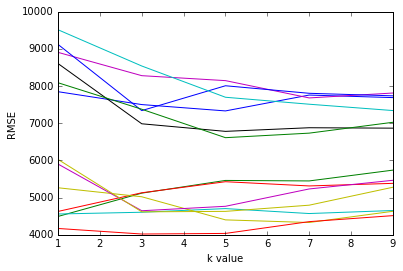

In [66]:
import matplotlib.pyplot as plt
%matplotlib inline

for k,v in k_rmse_results.items():
    x = list(v.keys())
    y = list(v.values())
    
    plt.plot(x,y)
    plt.xlabel('k value')
    plt.ylabel('RMSE')

plt.show()

## Multivariate KNN

In [67]:
# Compute average RMSE across different `k` values for each feature.
feature_avg_rmse =  OrderedDict()
for k,v in k_rmse_results.items():
    avg_rmse = np.mean(list(v.values()))
    feature_avg_rmse[k] = avg_rmse
series_avg_rmse = pd.Series(feature_avg_rmse)
series_avg_rmse.sort_values()

horsepower           4219.377860
width                4618.910560
curb-weight          4730.075815
highway-mpg          5069.469256
length               5176.394904
city-mpg             5202.409003
wheel-base           5252.392462
compression-rate     7166.073599
bore                 7222.472445
normalized-losses    7624.407151
stroke               8000.240467
peak-rpm             8119.365233
height               8163.346266
dtype: float64

In [68]:
def knn_train_test(train_cols, target_col, df):
    np.random.seed(1)
    
    # Randomize order of rows in data frame.
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)

    # Divide number of rows in half and round.
    last_train_row = int(len(rand_df) / 2)
    
    # Select the first half and set as training set.
    # Select the second half and set as test set.
    train_df = rand_df.iloc[0:last_train_row]
    test_df = rand_df.iloc[last_train_row:]
    
    k_values = [5]
    k_rmses =  OrderedDict()
    
    for k in k_values:
        # Fit model using k nearest neighbors.
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(train_df[train_cols], train_df[target_col])

        # Make predictions using model.
        predicted_labels = knn.predict(test_df[train_cols])

        # Calculate and return RMSE.
        mse = mean_squared_error(test_df[target_col], predicted_labels)
        rmse = np.sqrt(mse)
        
        k_rmses[k] = rmse
    return k_rmses

k_rmse_results =  OrderedDict()

two_best_features = ['horsepower', 'width']
rmse_val = knn_train_test(two_best_features, 'price', numeric_cars)
k_rmse_results["two best features"] = rmse_val

three_best_features = ['horsepower', 'width', 'curb-weight']
rmse_val = knn_train_test(three_best_features, 'price', numeric_cars)
k_rmse_results["three best features"] = rmse_val

four_best_features = ['horsepower', 'width', 'curb-weight', 'city-mpg']
rmse_val = knn_train_test(four_best_features, 'price', numeric_cars)
k_rmse_results["four best features"] = rmse_val

five_best_features = ['horsepower', 'width', 'curb-weight' , 'city-mpg' , 'highway-mpg']
rmse_val = knn_train_test(five_best_features, 'price', numeric_cars)
k_rmse_results["five best features"] = rmse_val

six_best_features = ['horsepower', 'width', 'curb-weight' , 'city-mpg' , 'highway-mpg', 'length']
rmse_val = knn_train_test(six_best_features, 'price', numeric_cars)
k_rmse_results["six best features"] = rmse_val

k_rmse_results

OrderedDict([('two best features', OrderedDict([(5, 3589.3132622073304)])),
             ('three best features', OrderedDict([(5, 3305.9401397969677)])),
             ('four best features', OrderedDict([(5, 3280.3807311630976)])),
             ('five best features', OrderedDict([(5, 3341.6024539726504)])),
             ('six best features', OrderedDict([(5, 3628.2611882141268)]))])

In [69]:
def knn_train_test(train_cols, target_col, df):
    np.random.seed(1)
    
    # Randomize order of rows in data frame.
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)

    # Divide number of rows in half and round.
    last_train_row = int(len(rand_df) / 2)
    
    # Select the first half and set as training set.
    # Select the second half and set as test set.
    train_df = rand_df.iloc[0:last_train_row]
    test_df = rand_df.iloc[last_train_row:]
    
    k_values = [i for i in range(1, 25)]
    k_rmses =  OrderedDict()
    
    for k in k_values:
        # Fit model using k nearest neighbors.
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(train_df[train_cols], train_df[target_col])

        # Make predictions using model.
        predicted_labels = knn.predict(test_df[train_cols])

        # Calculate and return RMSE.
        mse = mean_squared_error(test_df[target_col], predicted_labels)
        rmse = np.sqrt(mse)
        
        k_rmses[k] = rmse
    return k_rmses

k_rmse_results =  OrderedDict()

three_best_features = ['horsepower', 'width', 'curb-weight']
rmse_val = knn_train_test(three_best_features, 'price', numeric_cars)
k_rmse_results["three best features"] = rmse_val

four_best_features = ['horsepower', 'width', 'curb-weight', 'city-mpg']
rmse_val = knn_train_test(four_best_features, 'price', numeric_cars)
k_rmse_results["four best features"] = rmse_val

five_best_features = ['horsepower', 'width', 'curb-weight' , 'city-mpg' , 'highway-mpg']
rmse_val = knn_train_test(five_best_features, 'price', numeric_cars)
k_rmse_results["five best features"] = rmse_val

k_rmse_results

OrderedDict([('three best features',
              OrderedDict([(1, 3013.0109985241875),
                           (2, 2813.2859698259972),
                           (3, 3171.5852844786741),
                           (4, 3182.3137417981943),
                           (5, 3305.9401397969677),
                           (6, 3522.5068489003761),
                           (7, 3774.3772094554106),
                           (8, 3978.9691240211159),
                           (9, 3992.9236805888809),
                           (10, 4076.2381473803043),
                           (11, 4156.3883311318068),
                           (12, 4201.1071338594802),
                           (13, 4303.6267686132496),
                           (14, 4359.6932969897016),
                           (15, 4371.7711033728683),
                           (16, 4394.4846551644205),
                           (17, 4510.3997100574061),
                           (18, 4584.3109618654862),
                  

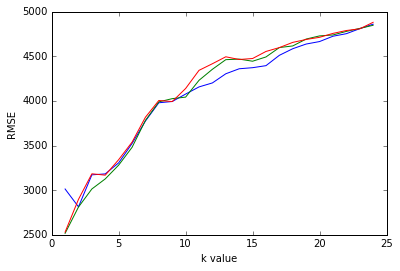

In [70]:
for k,v in k_rmse_results.items():
    x = list(v.keys())
    y = list(v.values())
    
    plt.plot(x,y)
    plt.xlabel('k value')
    plt.ylabel('RMSE')